In [10]:

import jax
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from ima.ima.mixing_functions import build_moebius_transform
from ima.ima.plotting import cart2pol
from gp_ima.ima import C_ima_digamma, C_ima_sample
from jax import numpy as jnp
import GPy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

plt.ion(); plt.style.use('seaborn-pastel')
np.random.seed(42)

In [30]:


n, d, D = 2500, 2, 2

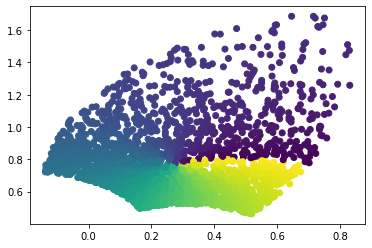

In [31]:

Z = np.random.uniform(-0.5, 0.5, size=(n, d))
_, c = cart2pol(Z[:, 1], Z[:, 0])

# plt.scatter(Z[:, 0], Z[:, 1], c=c)

A = ortho_group.rvs(dim=D)
A = jax.numpy.array(A)

alpha = 1.0
a = []
while len(a) < D:
    s = np.random.randn()
    if np.abs(s) > 0.5:
        a = a + [s]
a = jax.numpy.array(a)
b = jax.numpy.zeros(D)

mixing, _ = build_moebius_transform(alpha, A, a, b, epsilon=2)

X = jax.vmap(mixing)(Z)
plt.scatter(X[:, 0], X[:, 1], c=c)

In [ ]:


kernel = GPy.kern.RBF(2, ARD=False) + GPy.kern.Bias(2)
m = GPy.models.BayesianGPLVM(np.asarray(X), 2, kernel=kernel, num_inducing=100)
m.optimize_restarts(3, optimizer='lbfgs')

Optimization restart 1/3, f = 2870.7398173674064


In [ ]:
def C_ima(gplvm):
    from tqdm import trange
    return [C_ima_sample(gplvm) for _ in trange(500)]

In [ ]:

CIMA= C_ima(m)

In [ ]:
Zest = m.X.mean
Zest_uni_cima = jnp.column_stack([jax.scipy.stats.logistic.cdf(Zest[:, 0]),
                              jax.scipy.stats.logistic.cdf(Zest[:, 1])])
Zest_uni_cima -= 0.5

In [ ]:


_, cest = cart2pol(Zest[:, 0], Zest[:, 1])
plt.scatter(Zest[:, 0], Zest[:, 1], c=cest)

In [ ]:


_, cest = cart2pol(Zest_uni_cima[:, 0], Zest_uni_cima[:, 1])
plt.scatter(Zest_uni_cima[:, 0], Zest_uni_cima[:, 1], c=cest)

In [ ]:
plt.plot(CIMA)

In [ ]:
Ds = np.logspace(0, 3, 1000).astype(int)
plt.plot(Ds, [C_ima_digamma(max(1, int(np.log(D))), D) for D in Ds])